### 모듈 import

In [1]:
#!pip install pandas
#!pip install numpy
#!pip install matplotlib
#!pip install seaborn
#!pip install scikit-learn
#!pip install datasets
#!pip install transformers

In [2]:
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
from pprint import pprint

from sklearn.feature_extraction.text import TfidfVectorizer

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

from datasets import (load_dataset, 
                      load_metric, 
                      load_from_disk,
                      Dataset,
                      DatasetDict
)
from transformers import (
    AutoTokenizer,
    BertModel, BertPreTrainedModel,
    RobertaModel, RobertaPreTrainedModel,
    AdamW, get_linear_schedule_with_warmup,
    TrainingArguments,
)

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 데이터 load
MRC 데이터의 경우, HuggingFace에서 제공하는 datasets 라이브러리를 이용하여 접근이 가능합니다. <br>
해당 directory를 dataset_name 으로 저장한 후, 아래의 코드를 활용하여 불러올 수 있습니다.

Retrieval 과정에서 사용하는 문서 집합(corpus)은 ./data/wikipedia_documents.json 으로 저장되어있습니다. 약 5만 7천개의 unique 한 문서로 이루어져 있습니다.<br>

데이터셋은 편의성을 위해 Huggingface 에서 제공하는 datasets를 이용하여 pyarrow 형식의 데이터로 저장되어있습니다. 다음은 ./data 구조입니다.<br>


./data/ <br>
    ./train_dataset/ # 학습에 사용할 데이터셋. train 과 validation 으로 구성<br>
    ./test_dataset/  # 제출에 사용될 데이터셋. validation 으로 구성 <br>
    ./wikipedia_documents.json # 위키피디아 문서 집합. retrieval을 위해 쓰이는 corpus.<br>

In [3]:
# train_dataset을 불러오고 싶은 경우
from datasets import load_from_disk
dataset = load_from_disk("./train_dataset/")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['title', 'context', 'question', 'id', 'answers', 'document_id', '__index_level_0__'],
        num_rows: 3952
    })
    validation: Dataset({
        features: ['title', 'context', 'question', 'id', 'answers', 'document_id', '__index_level_0__'],
        num_rows: 240
    })
})


/opt/conda/lib/python3.8/site-packages/datasets/dataset_dict.py:1241: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(


#### JSON 파일 열기

In [4]:
with open('wikipedia_documents.json', "r", encoding="utf-8") as f:
    wiki = json.load(f)
    
wiki_corpus = list(
    dict.fromkeys([v["text"] for v in wiki.values()])
)

In [5]:
wiki_corpus[0]

'이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개요 형태로 나열하고 있다.\n\n이 목록은 명료화를 위해 두 부분으로 나뉘어 있다.\n\n# 첫 번째 부분은 바티칸 시국과 팔레스타인을 포함하여 유엔 등 국제 기구에 가입되어 국제적인 승인을 널리 받았다고 여기는 195개 나라를 나열하고 있다.\n# 두 번째 부분은 일부 지역의 주권을 사실상 (데 팍토) 행사하고 있지만, 아직 국제적인 승인을 널리 받지 않았다고 여기는 11개 나라를 나열하고 있다.\n\n두 목록은 모두 가나다 순이다.\n\n일부 국가의 경우 국가로서의 자격에 논쟁의 여부가 있으며, 이 때문에 이러한 목록을 엮는 것은 매우 어렵고 논란이 생길 수 있는 과정이다. 이 목록을 구성하고 있는 국가를 선정하는 기준에 대한 정보는 "포함 기준" 단락을 통해 설명하였다. 나라에 대한 일반적인 정보는 "국가" 문서에서 설명하고 있다.'

### 중복 문서 확인

중복 문서가 없다는 것을 확인할 수 있다.

In [6]:
print('raw 위키 문서의 개수:', len(list(wiki_corpus)))
print('중복 제거후 위키 문서의 개수:', len(list(set(wiki_corpus))))

raw 위키 문서의 개수: 56737
중복 제거후 위키 문서의 개수: 56737


### sentence 문장 길이 확인

In [7]:
doc_len = []
for doc in wiki_corpus:
    doc_len.append(len(doc))

print('가장 긴 document 길이: ', max(doc_len))
print('가장 짧은 document 길이: ', min(doc_len))
print('평균 document 길이: ', sum(doc_len)/len(doc_len) )

가장 긴 document 길이:  46099
가장 짧은 document 길이:  184
평균 document 길이:  750.8205932636552


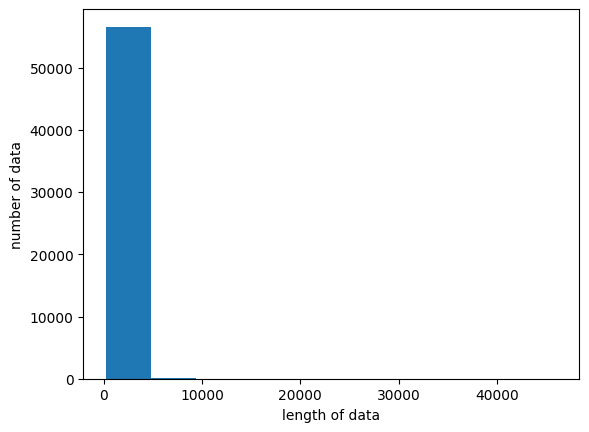

In [8]:
plt.hist(doc_len)
plt.xlabel("length of data")
plt.ylabel("number of data")
#plt.xlim(0, 10000)
plt.show()

왜 히스토그램이 이상한 것 같지😡

In [10]:
count = 0 
length = 750
for num in doc_len:
    if num >= length:
        count += 1
print('document의 길이가',length,'이상인 개수', count)

document의 길이가 750 이상인 개수 18281


### Tokenize 

In [11]:
model = 'klue/bert-base'
tokenizer = AutoTokenizer.from_pretrained(model)

Downloading: 100%|██████████| 425/425 [00:00<00:00, 363kB/s]
Downloading: 100%|██████████| 248k/248k [00:00<00:00, 320kB/s]  
Downloading: 100%|██████████| 495k/495k [00:00<00:00, 498kB/s]  
Downloading: 100%|██████████| 125/125 [00:00<00:00, 79.6kB/s]


In [13]:
tokenized_doc_len = []
for doc in wiki_corpus:
    tokenized_doc_len.append(len(tokenizer.tokenize(doc)))

가장 긴 tokenized document 길이: 27539
가장 짧은 tokenized document 길이: 54
평균 tokenized document 길이: 401.88920810053406


In [ ]:
print('총 tokenized document 개수:', len(tokenized_doc_len))
print('가장 긴 tokenized document 길이:', max(tokenized_doc_len))
print('가장 짧은 tokenized document 길이:', min(tokenized_doc_len))
print('평균 tokenized document 길이:', sum(tokenized_doc_len)/len(tokenized_doc_len))

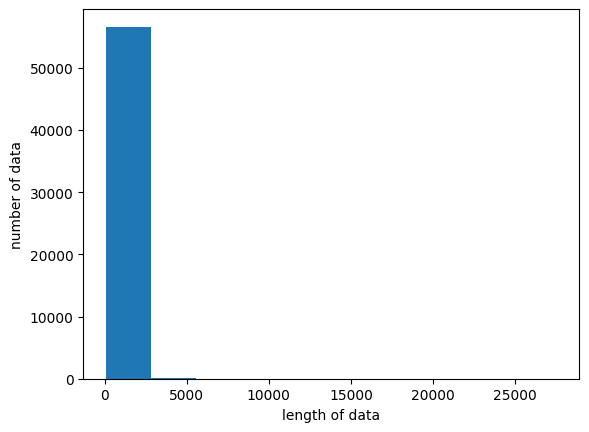

In [14]:
plt.hist(tokenized_doc_len)
plt.xlabel("length of data")
plt.ylabel("number of data")
plt.show()

In [15]:
count = 0 
length = 401
for num in tokenized_doc_len:
    if num >= length:
        count += 1
print('token의 길이가',length,'이상인 개수', count)

token의 길이가 401 이상인 개수 18172
